### Preprocessing

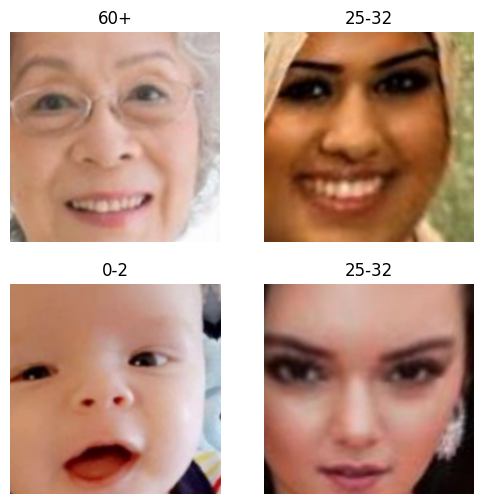

In [10]:
from fastai.vision.all import Path, ImageDataLoaders, Resize, aug_transforms, Normalize, imagenet_stats
from fastai.vision.all import vision_learner, resnet50, accuracy, get_image_files, ClassificationInterpretation
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, EarlyStoppingCallback, ShowGraphCallback, SaveModelCallback
import torch
import os
from sklearn.model_selection import train_test_split

def extract_age_from_filename(fname):
    age = fname.name.split('_')[0]
    if age.isdigit():
        age = int(age)
        if age <= 2:
            return '0-2'
        elif age <= 6:
            return '4-6'
        elif age <= 13:
            return '8-13'
        elif age <= 20:
            return '15-20'
        elif age <= 32:
            return '25-32'
        elif age <= 43:
            return '38-43'
        elif age <= 53:
            return '48-53'
        else:
            return '60+'
    else:
        return 'Unknown'

def label_func(fname):
    return extract_age_from_filename(fname)

path = Path('./dataset/archive/utkcropped')  # Path vers le dataset

# Constitution des sets de train/valid/test
all_files = get_image_files(path)
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
train_files, valid_files = train_test_split(train_files, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

def splitter(files):
    # Renvoie une fonction que fastAI peut utiliser pour splitter
    train_idx = [i for i, o in enumerate(files) if o in train_files]
    valid_idx = [i for i, o in enumerate(files) if o in valid_files]
    return train_idx, valid_idx

face_age_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=splitter,
    get_y=label_func,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
)

# Load dans les DataLoaders
dls = face_age_block.dataloaders(path, bs=64)

# On affiche quelques exemples pour vérifier que tout est bon
dls.show_batch(max_n=4)

### Fine-tuning

In [11]:
from fastai.vision.all import resnet34

# On s'assure qu'on fait usage du GPU
if torch.cuda.is_available():
    print('GPU disponible')
    dls = dls.cuda()
    
learner = vision_learner(dls, resnet34, metrics=[accuracy], pretrained=True, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3), SaveModelCallback(monitor='valid_loss')])

GPU disponible


Recherche de learning rate optimale...


Entraînement des couches externes...


epoch,train_loss,valid_loss,accuracy,time
0,2.828120,1.904070,0.340363,03:11
1,2.354011,1.625263,0.470687,04:11
2,2.105583,1.505584,0.516449,03:43
3,1.854939,1.367070,0.532476,03:00
4,1.633943,1.298463,0.545761,02:59
5,1.480678,1.233937,0.548925,03:00
6,1.361320,1.189407,0.556727,02:58
7,1.293026,1.153899,0.561366,02:58
8,1.237001,1.124395,0.571278,02:58
9,1.179713,1.095543,0.586461,02:58


Better model found at epoch 0 with valid_loss value: 1.9040697813034058.


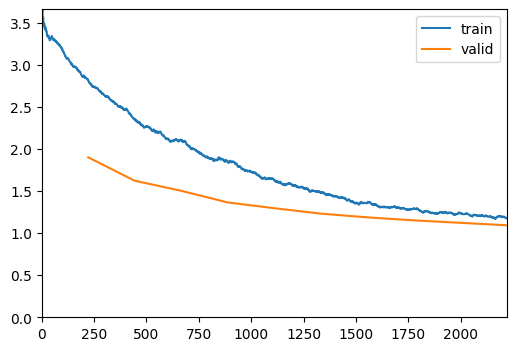

Better model found at epoch 1 with valid_loss value: 1.6252626180648804.
Better model found at epoch 2 with valid_loss value: 1.5055838823318481.
Better model found at epoch 3 with valid_loss value: 1.367069959640503.
Better model found at epoch 4 with valid_loss value: 1.298463225364685.
Better model found at epoch 5 with valid_loss value: 1.2339369058609009.
Better model found at epoch 6 with valid_loss value: 1.1894068717956543.
Better model found at epoch 7 with valid_loss value: 1.1538991928100586.
Better model found at epoch 8 with valid_loss value: 1.1243947744369507.
Better model found at epoch 9 with valid_loss value: 1.0955427885055542.


epoch,train_loss,valid_loss,accuracy,time
0,1.096109,1.018944,0.607760,03:29
1,1.003326,0.950515,0.634121,03:31
2,0.957121,0.912850,0.649304,03:30
3,0.889411,0.868504,0.659848,03:30
4,0.827759,0.843086,0.667018,03:31
5,0.796200,0.840642,0.668073,03:29
6,0.746138,0.830574,0.672923,03:29
7,0.690355,0.836658,0.677140,03:30
8,0.642577,0.838570,0.676930,03:29
9,0.639803,0.836777,0.674399,03:30


Better model found at epoch 0 with valid_loss value: 1.0189443826675415.


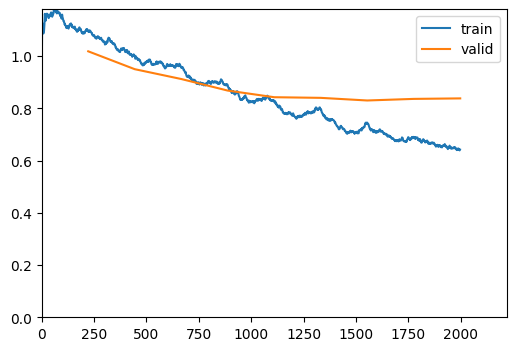

Better model found at epoch 1 with valid_loss value: 0.9505149126052856.
Better model found at epoch 2 with valid_loss value: 0.9128499031066895.
Better model found at epoch 3 with valid_loss value: 0.8685038685798645.
Better model found at epoch 4 with valid_loss value: 0.843085765838623.
Better model found at epoch 5 with valid_loss value: 0.8406416773796082.
Better model found at epoch 6 with valid_loss value: 0.830574095249176.
No improvement since epoch 6: early stopping
Recherche de learning rate optimale...


Entraînement du modèle...


epoch,train_loss,valid_loss,accuracy,time
0,0.668589,0.826508,0.675664,03:31
1,0.670855,0.828327,0.672079,03:31
2,0.667210,0.829682,0.674399,03:30
3,0.646477,0.826919,0.673977,03:30


Better model found at epoch 0 with valid_loss value: 0.8265084624290466.


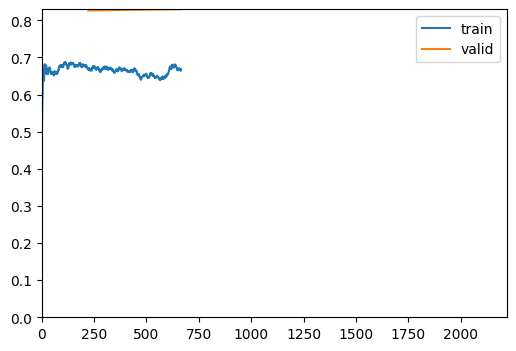

No improvement since epoch 0: early stopping


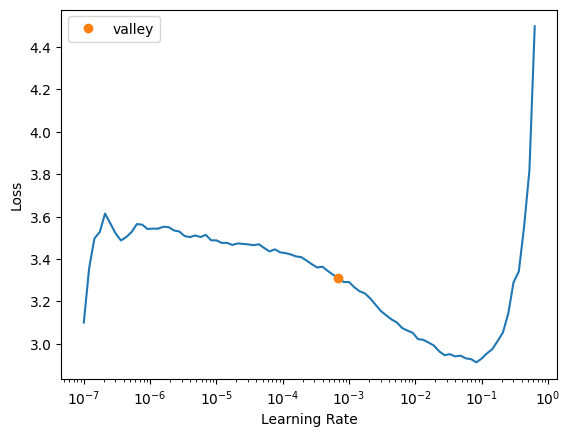

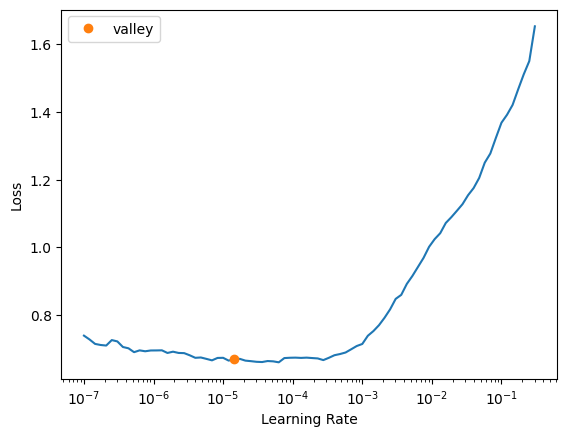

In [12]:
# Fine tuning initial de la couche de sortie
print("Recherche de learning rate optimale...")
lr_suggestion = learner.lr_find()

print("Entraînement des couches externes...")
learner.fine_tune(10, base_lr=lr_suggestion.valley, freeze_epochs=10, cbs=[ShowGraphCallback()])

# Entraînement du reste du modèle avec une learning rate plus basse
learner.unfreeze()

print("Recherche de learning rate optimale...")
lr_suggestion_fine_tune = learner.lr_find()

print("Entraînement du modèle...")
learner.fit_one_cycle(10, lr_max=lr_suggestion_fine_tune.valley/3, cbs=[ShowGraphCallback()])

### Test des performances

Test Accuracy: 0.6727119088172913


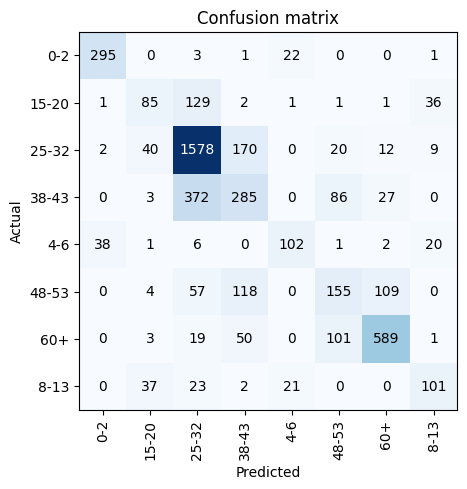

In [13]:
# Test set
test_dl = learner.dls.test_dl(test_files, with_labels=True)

preds, targs, decoded_preds = learner.get_preds(dl=test_dl, with_decoded=True)

# On calcule l'accuracy
print(f"Test Accuracy: {accuracy(preds, targs).item()}")

# On utilise ClassificationInterpretation pour plot la matrice de confusion
interp = ClassificationInterpretation.from_learner(learner, dl=test_dl)
interp.plot_confusion_matrix()